In [1]:
import sys
sys.path.append('..')
import sklearn
from tsai.basics import *
from swdf.utils import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from itertools import chain
from swdf.losses import LossFactory
from swdf.metrics import ValidationMetricsHandler, LossMetrics



os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# FSMY 10.7 Indices Forecasting for Neural Network Ensembles Comparison

This file contains a similar implementation to the one used by [Daniell, J. and Mehta, P. (2024)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023SW003785), where they use an ensemble of several neural network models and Principal Component Analysis (PCA) to accurately forecast these indices. In their approach, they split the dataset into segments of 10 weeks, with 6 weeks for training, 2 weeks for validation, and 2 weeks for testing. They then compare their results against a persistence baseline and present these comparisons as a benchmark.


In [2]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_solfsmy = yaml2dict('./config/solfsmy.yaml', attrdict=True)
config_train = config_solfsmy.train
config_data = config_solfsmy.data 

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_train, 
                   "data":AttrDict({**config_data})})

# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

In [3]:
config

```json
{ 'arch': {'dropout': 0.2, 'patch_len': 8},
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 32,
  'data': { 'add_time_channels': False,
            'data_columns': ['F10', 'S10', 'M10', 'Y10'],
            'data_nb': './solfsmy_data.ipynb',
            'data_path': '../data/SOLFSMY.TXT',
            'data_time_columns': ['Year', 'DDD'],
            'data_url': 'https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT',
            'df_save_path': './preprocessed_data/dataframes/solfsmy.pkl',
            'exp_pipe_save_path': './preprocessed_data/pipelines/preproc_solfsmy.pkl',
            'force_download': False,
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_solfsmy.pkl'},
  'horizon': 6,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 7,
  'loss_config': {},
  'loss_func': 'wMSE',
  'lr_max': None,
  'main_metric': 'default',
  'metrics': None,
  'n_epoch': 30,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [4]:
df, preproc_pipe, exp_pipe = generate_preprocessed_data(config.data)

df

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Datetime
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9862,2024,2,2460312.0,137.399994,157.899994,124.500000,133.899994,151.199997,173.699997,162.100006,175.000000,1E11,1,E,1,1,2024-01-02 12:00:00
9863,2024,3,2460313.0,135.500000,158.000000,128.100006,133.899994,153.899994,173.699997,165.800003,175.000000,1E11,1,E,1,1,2024-01-03 12:00:00
9864,2024,4,2460314.0,121.599998,158.100006,129.500000,133.899994,159.399994,173.600006,169.899994,175.100006,1E11,1,E,1,1,2024-01-04 12:00:00
9865,2024,5,2460315.0,147.600006,158.199997,132.600006,133.899994,163.899994,173.500000,173.100006,175.199997,1E11,1,E,1,1,2024-01-05 12:00:00


In [5]:
df_time = df.copy()
df_time.set_index('Datetime', inplace=True)
weekly_groups = list(df_time.resample('7D').indices.values())

In [6]:
# Lists to hold the intervals for each set
training_intervals = []
training_combinations = []
testing_intervals = []
testing_combinations = []
validation_intervals = []
validation_combinations = []

# Iterate over the groups in chunks of 10 weeks
for i in range(0, len(list(weekly_groups)), 10):
    chunk = list(weekly_groups)[i:i+10]
   
    # Extract intervals for training, testing, and validation
    if len(chunk) >= 6:
        training_combinations += list(np.arange(i, i+6))
        training_intervals.append((chunk[:6]))
    if len(chunk) >= 8:
        testing_combinations += list(np.arange(i+6, i+8))
        testing_intervals.append(chunk[6:8])
    if len(chunk) >= 10:
        validation_combinations += list(np.arange(i+8, i+10))
        validation_intervals.append(chunk[8:10])

validation_intervals.__delitem__(-1) # To avoid unhomegeneous arrays
validation_intervals.__delitem__(-1)

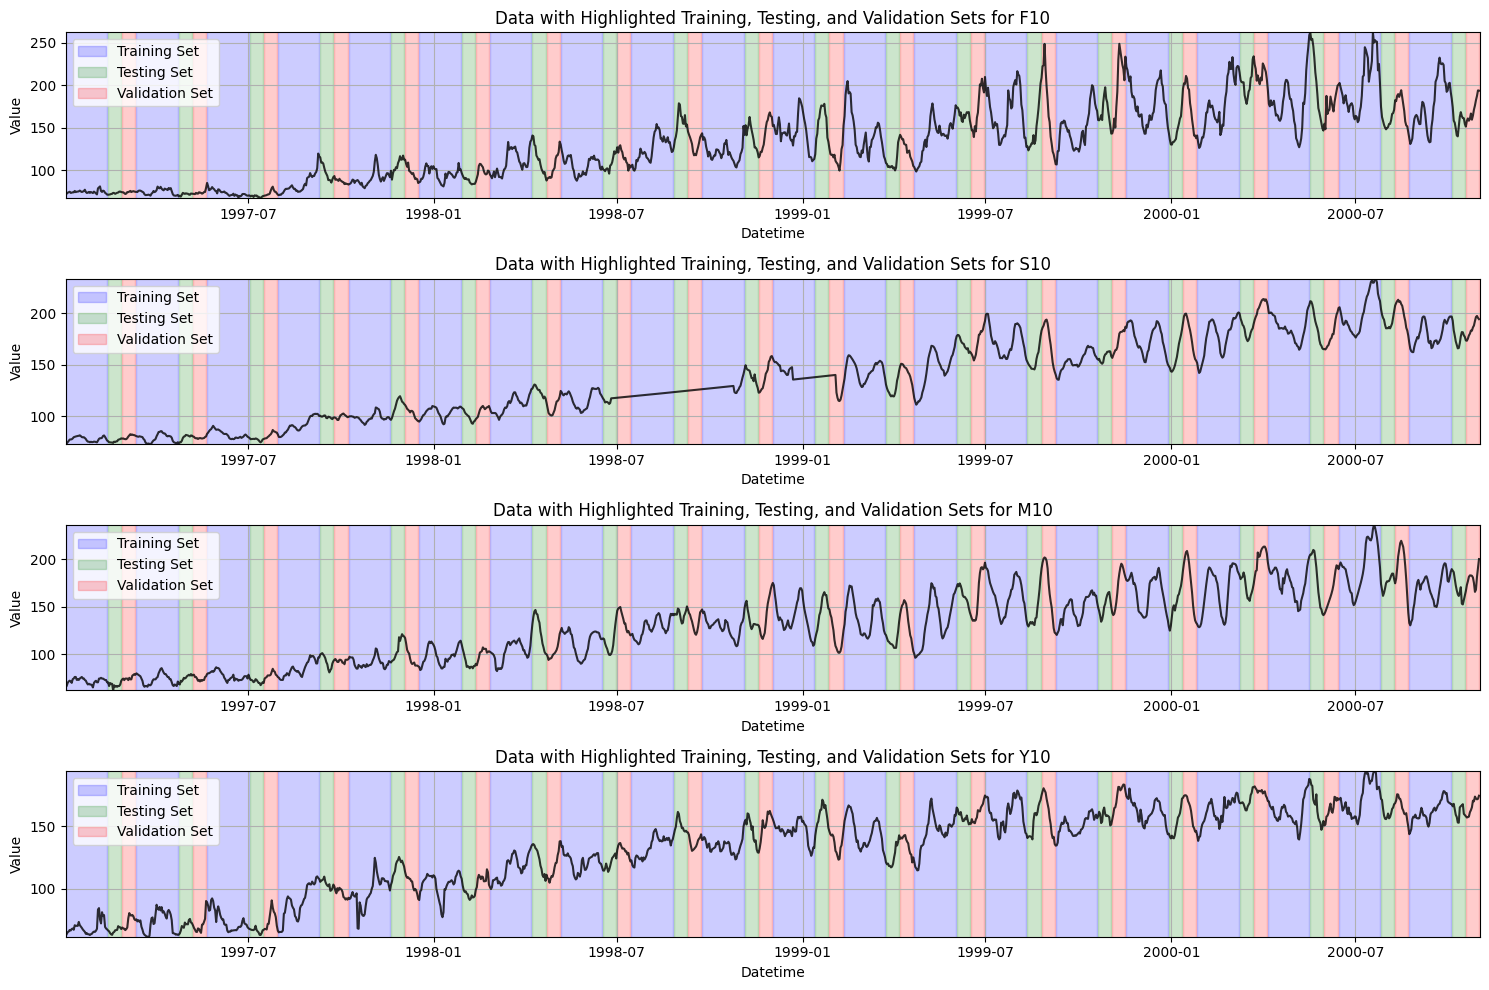

In [7]:
# Assuming df is your DataFrame and training_intervals, testing_intervals, validation_intervals are your interval lists
columns = ['F10', 'S10', 'M10', 'Y10']
full_intervals = 20

# Function to plot shaded intervals
def plot_intervals(ax, intervals, color, label, column):
    for interval in intervals:
        interval = chain.from_iterable(interval)
        ax.fill_between(df.Datetime.loc[interval], df[column].min(), df[column].max(), color=color, alpha=0.2, label=label)
        label = None  # Avoid duplicate labels in legend

# Create a figure and subplots
fig, axs = plt.subplots(len(columns), 1, figsize=(15, 10))

# Ensure axs is always a list for consistency
if len(columns) == 1:
    axs = [axs]

for ax, column in zip(axs, columns):
    # Plotting each set with a different color
    plot_intervals(ax, training_intervals[:full_intervals], 'blue', 'Training Set', column)
    plot_intervals(ax, testing_intervals[:full_intervals], 'green', 'Testing Set', column)
    plot_intervals(ax, validation_intervals[:full_intervals], 'red', 'Validation Set', column)

    # Define the plot period for each column
    plot_period = df.Datetime < df.Datetime.min() + pd.Timedelta(weeks=full_intervals*10)
    ax.plot(df[plot_period]['Datetime'], df[plot_period][column], alpha=0.8, color='black')

    # Enhancing the plot
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.set_title(f'Data with Highlighted Training, Testing, and Validation Sets for {column}')
    ax.set_xlim((df.Datetime.min(), df.Datetime.min() + pd.Timedelta(weeks=full_intervals*10)))
    ax.set_ylim((df[plot_period][column].min(), df[plot_period][column].max()))
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

In [8]:
X_val, y_val, split_val = sliding_window_generator(df, 0, comb=validation_combinations, segments=weekly_groups, data_columns=config.data.data_columns, config=config)
X_train, y_train, split_train = sliding_window_generator(df, split_val[-1]+1, comb=training_combinations, segments=weekly_groups, data_columns=config.data.data_columns, config=config)
X_test, y_test, split_test = sliding_window_generator(df, split_train[-1]+1, comb=testing_combinations, segments=weekly_groups, data_columns=config.data.data_columns, config=config) 

X = np.concatenate([X_val, X_train, X_test])
y = np.concatenate([y_val, y_train, y_test])

splits = (split_train, split_val, split_test)
splits, X.shape, y.shape

(((#4230) [280,281,282,283,284,285,286,287,288,289...],
  (#280) [0,1,2,3,4,5,6,7,8,9...],
  (#282) [4510,4511,4512,4513,4514,4515,4516,4517,4518,4519...]),
 (4792, 4, 7),
 (4792, 4, 6))

In [ ]:
thresholds = yaml2dict("preprocessed_data/categorization/thresholds_solfsmy.yaml")
solact_levels = yaml2dict("preprocessed_data/categorization/activity_levels_solfsmy.yaml")
thresholds, solact_levels

In [10]:
df_F10 = load_object("./preprocessed_data/dataframes/F10_historical.pkl")

df_F107_cat = pd.Series(get_classified_columns(df_F10, thresholds, solact_levels)['F10_Cat'])
historical_distribution = df_F107_cat.value_counts(normalize=True).to_dict()

historical_distribution

{'moderate': 0.5065749000307598,
 'low': 0.18390495232236234,
 'high': 0.16145032297754536,
 'elevated': 0.14806982466933252}

In [11]:
total_weight = sum(1.0 - value for value in historical_distribution.values())
weights_raw = {k: (1.0 - v) / total_weight for k, v in historical_distribution.items()}

weights = {'All': [weights_raw[k] for k in solact_levels['F10']]}
weights, weights_raw

({'All': [0.27203168255921256,
   0.16447503332308008,
   0.2839767251102225,
   0.2795165590074849]},
 {'moderate': 0.16447503332308008,
  'low': 0.27203168255921256,
  'high': 0.2795165590074849,
  'elevated': 0.2839767251102225})

epoch,train_loss,valid_loss,Loss_Low,Loss_Moderate,Loss_Elevated,Loss_High,time
0,39.455658,39.685074,1.727373,17.702616,12.275488,7.979599,00:00
1,39.973183,37.702999,1.565889,16.380106,12.120135,7.636867,00:00
2,38.378357,38.606125,1.683406,17.496981,11.769676,7.656060,00:00
3,36.812889,42.040947,1.369205,16.291878,14.276956,10.102909,00:00
4,38.528496,46.035412,1.363085,17.417223,15.521459,11.733644,00:00
5,36.337078,49.174690,2.195799,23.475000,12.888098,10.615794,00:00
6,35.097771,34.632774,1.643231,15.879897,10.643032,6.466619,00:00
7,34.955471,34.380985,1.719023,16.474665,10.110706,6.076590,00:00
8,35.438427,50.925117,1.929682,24.451147,13.624431,10.919861,00:00
9,34.018379,35.939503,1.667099,16.680738,11.171535,6.420132,00:00


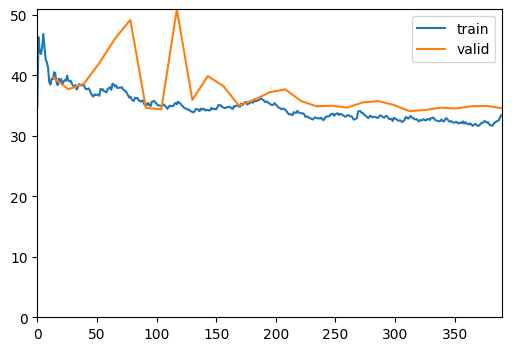

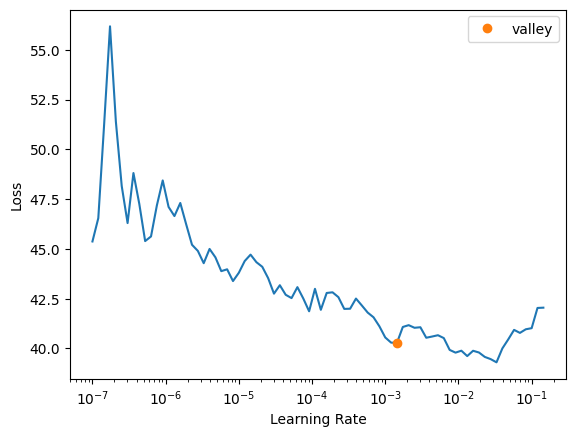

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the loss function with the provided thresholds and weights
loss = LossFactory(thresholds=thresholds, weights=weights).create(
    config.loss_func, **config.loss_config
).to(device)

# Set up metrics 
if config.metrics_handler_path is not None:
    metrics_handler = load_object(config.metrics_handler_path)
else:
    metrics_handler = LossMetrics(loss, 'SolFSMY')
metrics = metrics_handler.get_metrics()

# Initialize the callback list, including WandbCallback if enabled
wandb_callback = WandbCallback(log_preds=False)
callbacks = L(wandb_callback) if config.wandb.enabled else L()
callbacks += ShowGraphCallback()

learn = TSForecaster(
    X, y, splits=splits, 
    batch_size=config.bs,
    pipelines=[preproc_pipe, exp_pipe], 
    arch=config.arch_name, 
    metrics=metrics,
    loss_func=loss,
    arch_config=dict(config.arch), 
    init=config.init_weights,
    cbs= callbacks, 
    partial_n=config.partial_n)
learn.to(device)

try: # In some extreme cases it can fail and return an error
    lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max
except:
    lr_max = 1e-3

learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)

In [13]:
from torch.utils.data import TensorDataset
from fastai.tabular.all import *
from swdf.models import PersistenceModel

X_test = torch.tensor(X[splits[2]], dtype=torch.float32).to(device)
y_test = torch.tensor(y[splits[2]], dtype=torch.float32).to(device)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

model = PersistenceModel(config.horizon)

dls = DataLoaders(test_dl)

learn_persistence = Learner(dls, model, loss_func=loss)

y_persistence_preds, y_persistence = learn_persistence.get_preds(dl=test_dl)
y_persistence_preds.shape, y_persistence.shape

(torch.Size([282, 4, 6]), torch.Size([282, 4, 6]))

In [ ]:
# Save the persistence model
torch.save(y_persistence_preds, 'tmp/y_persistence_preds.pt')
torch.save(y_persistence, 'tmp/y_persistence.pt') 

In [ ]:
learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] 

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]

print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

In [ ]:
if config.metrics_handler_path is not None:
    valid_metrics = learn.recorder.metrics 
else:
    valid_metrics = [AttrDict({
        "name": config.loss_func,
        "value": learn.validate()[0]
    })]

%store valid_metrics

print({metric.name: metric.value for metric in valid_metrics})

In [ ]:
best_valid_metrics = None
%store -r best_valid_metrics

save_all_or_best = (
    config.is_optuna_study and 
    metrics_handler.are_best_values(best_valid_metrics, valid_metrics)
) or not config.is_optuna_study

if save_all_or_best:
    best_valid_metrics = valid_metrics
    %store best_valid_metrics

    # Save all relevant components locally
    learn.save_all(path='tmp', verbose=True, learner_fname="learner_NNE_solfsmy", model_fname="model_NNE_solfsmy")
    
    # Save the learner to Wandb if online and enabled
    if run is not None and config.wandb_mode and config.wandb_log_learner:
        run.log_artifact('tmp', type='learner', name='solfsmy')
    
    # Save the best model with relevant configuration
    model = {
        'models': [learn.model],
        'lookback': config.lookback,
        'horizon': config.horizon,
        'data_columns': config.data.data_columns,
        'thresholds': thresholds
    }
    
    torch.save(model, 'models/best/best_model_solfsmy.pth')


In [ ]:
if run is not None:
    run.finish()